1. furnance와 molten_volume 둘다 없는 것 'D'로 나머지 furnance 'C' -> 'D' 모두 드랍 (O)
2. 이상치 처리 
    - lof, iso 유지 (O)
    - 이상치 처리 방식 추가
        1. IQR 방식
            - IQR의 계수를 10까지 늘렸을 떄,
                - 데이터 수 : 92014 -> 46650
                - 불합격 데이터 비율 : 4.36% -> 1.04% (fail 데이터가 4000여개 중 3500여개 사라짐)
            - 10 이상으로 늘려도 값은 같았음
            - 결론 : 적용하지 않는 것이 좋겠음
        2. Percentile
3. 불균형 처리
    - ADASYN 추가
    - (선택) mold_code 기준 많은 code만 제거 (8722, 8412 -> 20000, 8917->30000)
4. PCA

# Data Load

In [ ]:
from kamp.preprocess import KampDataLoader

DATA_PATH = './data/경진대회용 주조 공정최적화 데이터셋.csv'

data_loader = KampDataLoader(
    path = DATA_PATH,

    outlier_method='iso',
    iso_outlier_rate=0.0075, # 0.0075

    p_threshold=0.05,
    get_useful_p_data=True,
                             
    do_resample=False,
    downsampled_pass_rate=1.0,
    upsampled_fail_rate_about_pass=0.40
)

data_loader.process()

data = data_loader.load()

x_train = data['train_data']
y_train = data['train_label']
x_test = data['test_data']
y_test=  data['test_label']

==================== [Data Process Start] ==================== 

[Process Log] Loading Raw Data...
[Process Log] Done

[Process Log] Processing Nan Value...
[Process Log] Done

[Process Log] Feature Engineering...
[Process Log] Done

[Process Log] Encoding Categorical Features...
[Process Log] Done

[Process Log] Removing Outliers (IsoForest)...


/home/sangho/ML/competition/factory/kamp/preprocess.py:68: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data.loc[:,feature] = data.loc[:, feature].fillna(fill_val)


[Outlier-Remover Log] With Outliers Shape : (89753, 23)
[Outlier-Remover Log] Without Outliers Shape : (89079, 23)
[Process Log] Done

[Process Log] T-Testing...
[Process Log] Done

[Process Log] Data Scaling (MinMaxScaler)...
[Process Log] Done

[Process Log] Train Test Spliting...
[Process Log] Done

======================= [Done] =======================


In [7]:
x_test

,working,facility_operation_cycleTime,production_cycletime,high_section_speed,cast_pressure,biscuit_thickness,upper_mold_temp1,upper_mold_temp2,lower_mold_temp1,lower_mold_temp2,sleeve_temperature,EMS_operation_time,tryshot_signal,mold_code,heating_furnace,count_trend,passorfail
0,1.0,0.118557,0.278008,0.288660,0.947883,0.120853,0.091737,0.039839,0.464183,0.159664,0.051336,0.00,0.0,0.500000,0.0,0.0,0.0
1,1.0,0.131443,0.253112,0.288660,0.944625,0.120853,0.149860,0.042210,0.544413,0.130952,0.404360,0.92,0.0,0.333333,0.0,0.0,0.0
2,1.0,0.123711,0.246888,0.288660,0.944625,0.132701,0.057423,0.036282,0.593123,0.086835,0.325598,0.92,0.0,1.000000,0.0,0.0,0.0
3,1.0,0.126289,0.275934,0.288660,0.941368,0.118483,0.123950,0.041262,0.710602,0.114846,0.271449,0.92,0.0,1.000000,1.0,0.0,0.0
4,1.0,0.123711,0.244813,0.288660,0.941368,0.125592,0.060224,0.040550,0.673352,0.089636,0.316456,0.92,0.0,1.000000,0.5,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
17811,1.0,0.136598,0.255187,0.288660,0.941368,0.113744,0.148459,0.046004,0.575931,0.125350,0.263713,0.92,0.0,0.166667,1.0,0.0,0.0
17812,1.0,0.144330,0.170124,0.288660,0.436482,0.132701,0.130952,0.028693,0.315186,0.095938,0.305204,0.92,0.0,0.333333,0.5,1.0,1.0
17813,1.0,0.128866,0.251037,0.273196,0.921824,0.109005,0.127451,0.037942,0.550143,0.161765,0.309423,0.92,0.0,0.833333,1.0,0.0,0.0
17814,1.0,0.193299,0.244813,0.291237,0.947883,0.118483,0.133053,0.032013,0.358166,0.144258,0.094233,0.24,0.0,0.000000,0.5,0.0,0.0


# Modeling

In [8]:
# !pip install catboost
# !pip install lightgbm
# !pip install catboost

In [9]:
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier, ExtraTreesClassifier, AdaBoostClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis, QuadraticDiscriminantAnalysis
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import f1_score, confusion_matrix
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from sklearn.datasets import load_iris
import matplotlib.pyplot as plt
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
import random
import tensorflow as tf


# 모델 별 함수 설정

In [10]:
# 랜덤 시드 고정
np.random.seed(42)
tf.random.set_seed(42)
random.seed(42)

In [11]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import GradientBoostingClassifier, AdaBoostClassifier, RandomForestClassifier, ExtraTreesClassifier
from sklearn.discriminant_analysis import LinearDiscriminantAnalysis
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier

# 선형 모델 설정 함수
def linear_model_setting():
    models = [
        ('lr', LogisticRegression(max_iter=200, random_state=42)),
        ('lda', LinearDiscriminantAnalysis()),
        ('ridge', LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200, random_state=42)),  # Ridge regression
        ('lasso', LogisticRegression(penalty='l1', solver='liblinear', max_iter=200, random_state=42))    # Lasso regression
    ]
    return models

# 부스팅 모델 설정 함수
def boosting_model_setting():
    models = [
        ('gb', GradientBoostingClassifier(n_estimators=10, random_state=42)),
        ('xgb', XGBClassifier(n_estimators=10, random_state=42)),
        ('catboost', CatBoostClassifier(silent=True, random_state=42)),  
        ('ada', AdaBoostClassifier(random_state=42)),  # AdaBoost
        ('lightgbm', LGBMClassifier(n_estimators=10, random_state=42))  
    ]
    return models

# 포레스트 모델 설정 함수
def forest_model_setting():
    models = [
        ('rf', RandomForestClassifier(n_estimators=10, random_state=42)),
        ('extra_rf', ExtraTreesClassifier(n_estimators=10, random_state=42)),
        ('rf_small', RandomForestClassifier(n_estimators=5, random_state=42)),  # Small RF
        ('rf_large', RandomForestClassifier(n_estimators=100, random_state=42)),  # Large RF
        ('rf_bootstrap', RandomForestClassifier(n_estimators=10, bootstrap=True, random_state=42))  # Bootstrap RF
    ]
    return models


In [12]:
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis
from sklearn.neural_network import MLPClassifier

# 거리 기반 모델 설정 함수
def distance_based_model_setting():
    models = [
        ('svc', SVC(probability=True, random_state=42)),
        ('knn', KNeighborsClassifier()),
        ('qda', QuadraticDiscriminantAnalysis()),
        ('linear_svc', SVC(kernel='linear', probability=True, random_state=42)),  # Linear SVC
        ('svm_poly', SVC(kernel='poly', probability=True, random_state=42)),      # Polynomial SVC
        ('svm_rbf', SVC(kernel='rbf', probability=True, random_state=42))         # RBF SVC
    ]
    return models

# 딥러닝 모델 설정 함수
def deep_learning_model_setting():
    models = [
        ('mlp', MLPClassifier(max_iter=200, random_state=42)),
        ('mlp_small', MLPClassifier(hidden_layer_sizes=(10,), max_iter=200, random_state=42)),  # Small MLP
        ('mlp_large', MLPClassifier(hidden_layer_sizes=(100,), max_iter=200, random_state=42)),  # Large MLP
        ('mlp_dropout', MLPClassifier(hidden_layer_sizes=(50,), max_iter=200, random_state=42)),  # MLP with dropout
        ('mlp_tanh', MLPClassifier(activation='tanh', max_iter=200, random_state=42))  # MLP with tanh activation
    ]
    return models


# 시각화 및 학습 함수 구성하기

In [13]:
import numpy as np
import matplotlib.pyplot as plt

# 피처 중요도를 시각화하는 함수
def plot_feature_importance(models, x_test):
    feature_names = x_test.columns  # x_test의 피처 이름 가져오기
    for name, model in models:
        if hasattr(model, 'feature_importances_'):
            importances = model.feature_importances_
        elif hasattr(model, 'coef_'):
            importances = np.abs(model.coef_[0])
        else:
            continue  # 중요도를 제공하지 않는 모델은 무시
        
        indices = np.argsort(importances)[::-1]
        
        # # 수평 막대 그래프
        # plt.figure()
        # plt.title(f'Feature Importances for {name}')
        # plt.barh(range(len(importances)), importances[indices], align='center')  # 수평 막대 그래프
        # plt.yticks(range(len(importances)), feature_names[indices])  # y축 라벨 설정
        # plt.xlim([0, np.max(importances) * 1.1])  # x축 범위 설정
        # plt.xlabel('Importance')
        # plt.gca().invert_yaxis()  # y축 순서 반전
        # plt.tight_layout()
        # plt.show()
        
        # 파레토 차트
        cumulative_importance = np.cumsum(importances[indices])  # 누적 중요도 계산
        cumulative_importance_percentage = cumulative_importance / cumulative_importance[-1] * 100  # 백분율로 변환
        
        plt.figure()
        plt.bar(range(len(importances)), importances[indices], align='center', color='b', alpha=0.6)  # 수직 막대 그래프
        plt.xticks(range(len(importances)), feature_names[indices], rotation=90)  # x축 라벨 설정
        plt.ylabel('Importance')
        plt.ylim([0, np.max(importances) * 1.1])  # y축 범위 설정
        
        # 누적 중요도 선 그래프
        plt.twinx()
        plt.plot(cumulative_importance_percentage, color='r', marker='o', linestyle='-', linewidth=2)
        plt.ylabel('Cumulative Importance (%)')
        plt.title(f'Feature Importances and Pareto Chart for {name}')
        
        # 누적 중요도 선 그래프
        plt.twinx()
        plt.plot(cumulative_importance_percentage, color='r', marker='o', linestyle='-', linewidth=2)
        plt.ylabel('Cumulative Importance (%)')
        plt.title(f'Feature Importances and Pareto Chart for {name}')
        
        plt.tight_layout()
        plt.show()


def evaluate_models(x_train, y_train, x_test, y_test, models):
    f1_scores = {}
    confusion_matrices = {}
    
    for name, model in models:
        # 모델 훈련
        model.fit(x_train, y_train)
        
        # 예측
        y_pred = model.predict(x_test)
        
        # F1 스코어 계산
        f1_scores[name] = f1_score(y_test, y_pred, average='weighted')
        
        # 혼동 행렬 계산
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

        # 피처 중요도 시각화
        plot_feature_importance([(name, model)], x_test)  # 모델 이름과 모델 객체를 리스트로 전달

    return f1_scores, confusion_matrices

# Base 모델로 Feature Importance 확인
# (Feature Importances 확인용이라 돌릴 필요 없음)

리니어 모델

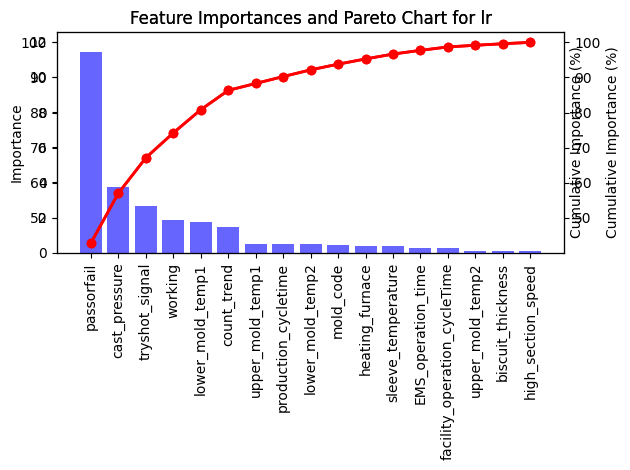

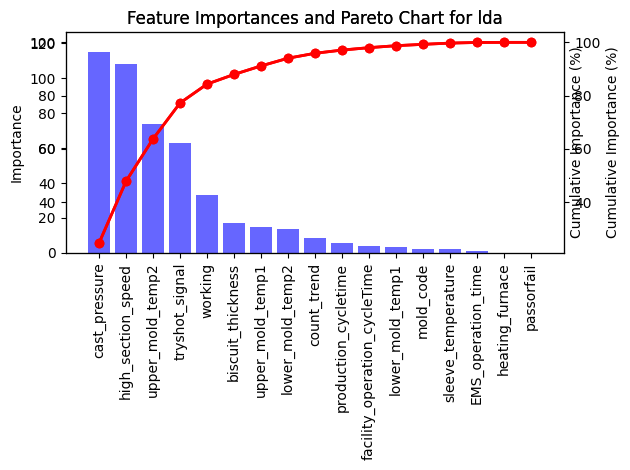

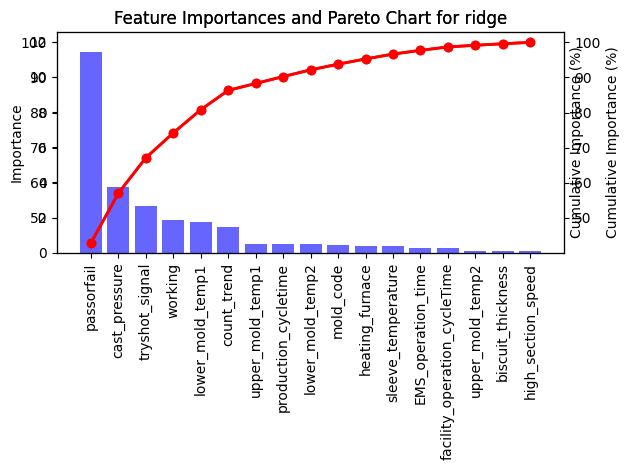

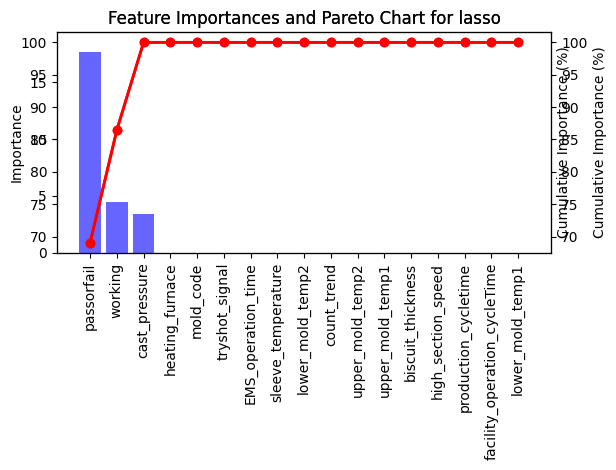

({'lr': 1.0, 'lda': 0.9908891703993632, 'ridge': 1.0, 'lasso': 1.0},
 {'lr': array([[17160,     0],
         [    0,   656]]),
  'lda': array([[17149,    11],
         [  143,   513]]),
  'ridge': array([[17160,     0],
         [    0,   656]]),
  'lasso': array([[17160,     0],
         [    0,   656]])})

In [14]:
# 모델 설정
models = linear_model_setting()

# 평가 모델 실행
evaluate_models(x_train, y_train, x_test, y_test, models)


거리기반 모델

/home/sangho/miniconda3/envs/ml3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")
/home/sangho/miniconda3/envs/ml3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:974: RuntimeWarning: divide by zero encountered in power
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/sangho/miniconda3/envs/ml3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:974: RuntimeWarning: invalid value encountered in multiply
  X2 = np.dot(Xm, R * (S ** (-0.5)))
/home/sangho/miniconda3/envs/ml3/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:977: RuntimeWarning: divide by zero encountered in log
  u = np.asarray([np.sum(np.log(s)) for s in self.scalings_])


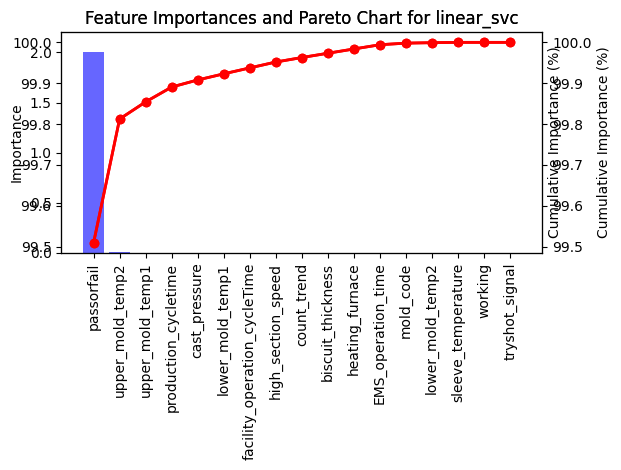

({'svc': 1.0,
  'knn': 1.0,
  'qda': 0.9451140477981489,
  'linear_svc': 1.0,
  'svm_poly': 1.0,
  'svm_rbf': 1.0},
 {'svc': array([[17160,     0],
         [    0,   656]]),
  'knn': array([[17160,     0],
         [    0,   656]]),
  'qda': array([[17160,     0],
         [  656,     0]]),
  'linear_svc': array([[17160,     0],
         [    0,   656]]),
  'svm_poly': array([[17160,     0],
         [    0,   656]]),
  'svm_rbf': array([[17160,     0],
         [    0,   656]])})

In [15]:
# 모델 설정
models = distance_based_model_setting()

# 평가 모델 실행
evaluate_models(x_train, y_train, x_test, y_test, models)

딥러닝 모델

In [16]:
# 모델 설정
models = deep_learning_model_setting()

# 평가 모델 실행
evaluate_models(x_train, y_train, x_test, y_test, models)

({'mlp': 1.0,
  'mlp_small': 1.0,
  'mlp_large': 1.0,
  'mlp_dropout': 1.0,
  'mlp_tanh': 1.0},
 {'mlp': array([[17160,     0],
         [    0,   656]]),
  'mlp_small': array([[17160,     0],
         [    0,   656]]),
  'mlp_large': array([[17160,     0],
         [    0,   656]]),
  'mlp_dropout': array([[17160,     0],
         [    0,   656]]),
  'mlp_tanh': array([[17160,     0],
         [    0,   656]])})

부스팅 모델

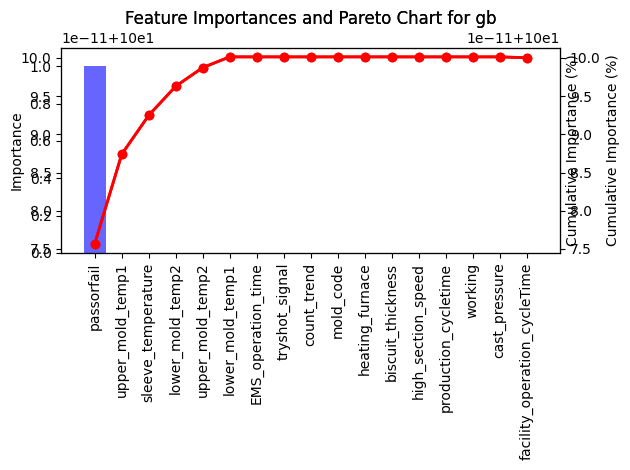

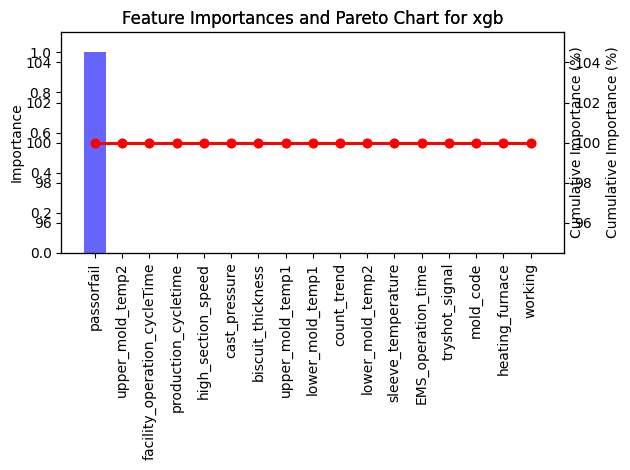

KeyboardInterrupt: 

In [17]:
# 모델 설정
models = boosting_model_setting()

# 평가 모델 실행
evaluate_models(x_train, y_train, x_test, y_test, models)

포레스트 모델

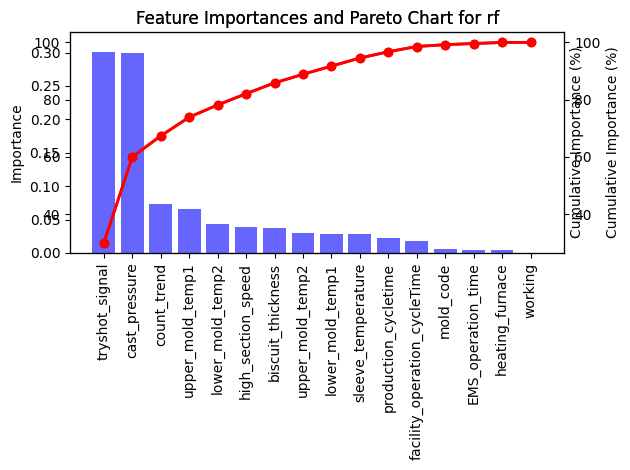

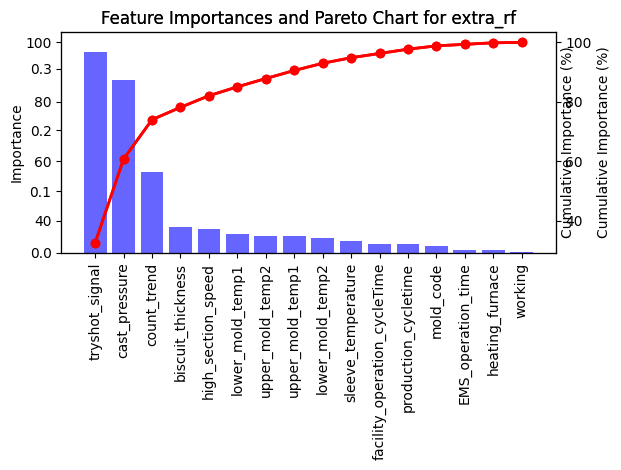

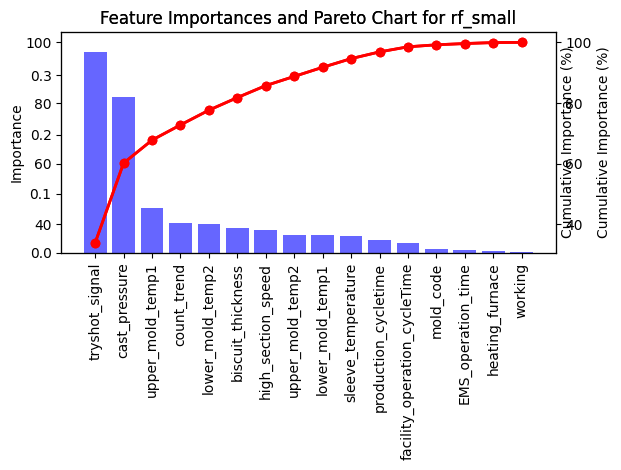

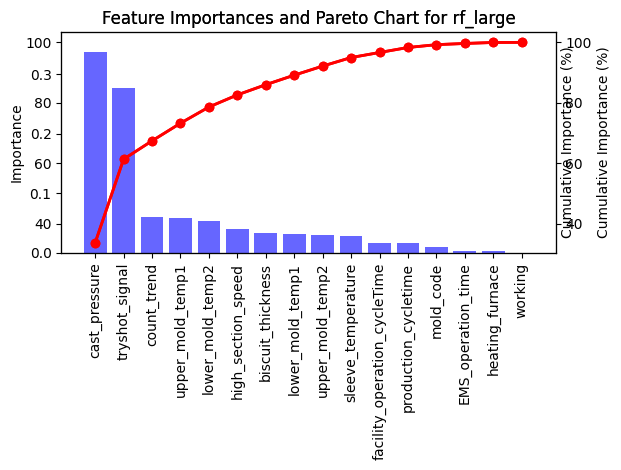

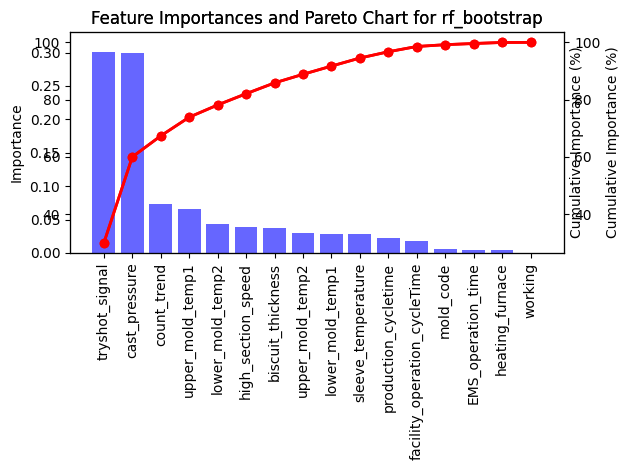

({'rf': 0.9945215449329332,
  'extra_rf': 0.9944319440321473,
  'rf_small': 0.9943238449326672,
  'rf_large': 0.995056097076999,
  'rf_bootstrap': 0.9945215449329332},
 {'rf': array([[17134,    26],
         [   70,   586]]),
  'extra_rf': array([[17141,    19],
         [   78,   578]]),
  'rf_small': array([[17125,    35],
         [   65,   591]]),
  'rf_large': array([[17133,    27],
         [   60,   596]]),
  'rf_bootstrap': array([[17134,    26],
         [   70,   586]])})

In [ ]:
# 모델 설정
models = forest_model_setting()

# 평가 모델 실행
evaluate_models(x_train, y_train, x_test, y_test, models)

# 스테킹 진행

모델 세팅 및 스테킹 모델 함수 만들기

In [ ]:
from sklearn.ensemble import (
    RandomForestClassifier,
    GradientBoostingClassifier,
    ExtraTreesClassifier,
    AdaBoostClassifier
)
from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.neural_network import MLPClassifier
from xgboost import XGBClassifier
from catboost import CatBoostClassifier
from lightgbm import LGBMClassifier
from sklearn.discriminant_analysis import QuadraticDiscriminantAnalysis, LinearDiscriminantAnalysis
 

# 모델 설정
select_model_dict = {
    # 선형 모델
    'lr': LogisticRegression(max_iter=200),
    'lda': LinearDiscriminantAnalysis(),
    'ridge': LogisticRegression(penalty='l2', solver='lbfgs', max_iter=200),  # Ridge regression
    'lasso': LogisticRegression(penalty='l1', solver='liblinear', max_iter=200),  # Lasso regression
    
    # 부스팅 모델
    'gb': GradientBoostingClassifier(n_estimators=10),
    'xgb': XGBClassifier(n_estimators=10),
    'catboost': CatBoostClassifier(silent=True),  
    'ada': AdaBoostClassifier(),  # AdaBoost
    'lightgbm': LGBMClassifier(n_estimators=10),
    
    # 포레스트 모델
    'rf': RandomForestClassifier(n_estimators=10),
    'extra_rf': ExtraTreesClassifier(n_estimators=10),
    'rf_small': RandomForestClassifier(n_estimators=5),  # Small RF
    'rf_large': RandomForestClassifier(n_estimators=100),  # Large RF
    'rf_bootstrap': RandomForestClassifier(n_estimators=10, bootstrap=True),  # Bootstrap RF

    # 거리 기반 모델
    'svc': SVC(probability=True),
    'knn': KNeighborsClassifier(),
    'qda': QuadraticDiscriminantAnalysis(),
    'linear_svc': SVC(kernel='linear', probability=True),  # Linear SVC
    'svm_poly': SVC(kernel='poly', probability=True),      # Polynomial SVC
    'svm_rbf': SVC(kernel='rbf', probability=True),         # RBF SVC

    # 딥러닝 모델
    'mlp': MLPClassifier(max_iter=200),
    'mlp_small': MLPClassifier(hidden_layer_sizes=(10,), max_iter=200),  # Small MLP
    'mlp_large': MLPClassifier(hidden_layer_sizes=(100,), max_iter=200),  # Large MLP
    'mlp_dropout': MLPClassifier(hidden_layer_sizes=(50,), max_iter=200),  # MLP with dropout
    'mlp_tanh': MLPClassifier(activation='tanh', max_iter=200)  # MLP with tanh activation
}

# 모델 설정 함수
def model_setting(selected_models=None):
    models = []
    
    if selected_models is None:
        selected_models = select_model_dict.keys()  # 모든 모델 선택
    
    for model_name in selected_models:
        if model_name in select_model_dict:
            models.append((model_name, select_model_dict[model_name]))
    
    return models


# 사용 예시
models = model_setting(['lr', 'rf', 'mlp', 'xgb'])  # 필요한 모델만 선택
meta_model = model_setting(['lr', 'rf', 'mlp', 'xgb'])



In [ ]:
# 스테킹 모델 함수 만들기
def stacking_model_with_f1_score(x_train, y_train, x_test, y_test, models, meta_model_func):
    # 메타 모델 정의
    meta_estimator = meta_model_func()  # 메타 모델 호출

    # 스태킹 분류기 생성
    stacking_model = StackingClassifier(estimators=models, final_estimator=meta_estimator)

    # 모델 훈련
    stacking_model.fit(x_train, y_train)

    # 각 기본 모델의 예측 및 F1 스코어 계산
    f1_scores = {}
    confusion_matrices = {}

    for name, model in models:
        model.fit(x_train, y_train)
        y_pred = model.predict(x_test)
        f1_scores[name] = f1_score(y_test, y_pred, average='weighted')
        confusion_matrices[name] = confusion_matrix(y_test, y_pred)

    # 스태킹 모델 예측 및 F1 스코어 계산
    y_pred_stacked = stacking_model.predict(x_test)
    f1_scores['stacking'] = f1_score(y_test, y_pred_stacked, average='weighted')
    confusion_matrices['stacking'] = confusion_matrix(y_test, y_pred_stacked)

    return f1_scores, confusion_matrices


스테킹 모델 학습

In [ ]:
from sklearn.ensemble import StackingClassifier

# 모델 설정
models = model_setting(['knn', 'catboost', 'rf', 'rf_small'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = AdaBoostClassifier()

# F1 스코어와 혼동 행렬 출력
f1_results, confusion_matrices = stacking_model_with_f1_score(x_train, y_train, x_test, y_test, models, lambda: meta_model)
print("F1 Scores:", f1_results)
print("Confusion Matrices:")
for name, cm in confusion_matrices.items():
    print(f"{name}:\n{cm}\n")


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1 Scores: {'knn': 0.9928162577891982, 'catboost': 0.9955725990474803, 'rf': 0.9952761775240252, 'rf_small': 0.9938247085443942, 'stacking': 0.9955209412694935}
Confusion Matrices:
knn:
[[17139    21]
 [  103   553]]

catboost:
[[17136    24]
 [   54   602]]

rf:
[[17137    23]
 [   60   596]]

rf_small:
[[17118    42]
 [   67   589]]

stacking:
[[17134    26]
 [   53   603]]



In [ ]:

# 모델 설정
models = model_setting(['knn', 'catboost', 'rf_bootstrap', 'rf_small'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = AdaBoostClassifier()

# F1 스코어와 혼동 행렬 출력
f1_results, confusion_matrices = stacking_model_with_f1_score(x_train, y_train, x_test, y_test, models, lambda: meta_model)
print("F1 Scores:", f1_results)
print("Confusion Matrices:")
print(f'meta_model : {meta_model}')
for name, cm in confusion_matrices.items():
    print(f"{name}:\n{cm}\n")

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1 Scores: {'knn': 0.9928162577891982, 'catboost': 0.9955725990474803, 'rf_bootstrap': 0.9945765123414245, 'rf_small': 0.9945169595697868, 'stacking': 0.9955859826956419}
Confusion Matrices:
meta_model : AdaBoostClassifier()
knn:
[[17139    21]
 [  103   553]]

catboost:
[[17136    24]
 [   54   602]]

rf_bootstrap:
[[17135    25]
 [   70   586]]

rf_small:
[[17121    39]
 [   58   598]]

stacking:
[[17132    28]
 [   50   606]]



In [ ]:

# 모델 설정
models = model_setting(['knn','gb','xgb','ridge', 'catboost', 'rf_bootstrap', 'rf', 'rf_small'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = AdaBoostClassifier()

# F1 스코어와 혼동 행렬 출력
f1_results, confusion_matrices = stacking_model_with_f1_score(x_train, y_train, x_test, y_test, models, lambda: meta_model)
print("F1 Scores:", f1_results)
print("Confusion Matrices:")
print(f'meta_model : {meta_model}')
for name, cm in confusion_matrices.items():
    print(f"{name}:\n{cm}\n")

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1 Scores: {'knn': 0.9928162577891982, 'gb': 0.9908251149248342, 'xgb': 0.9938984252256179, 'ridge': 0.9909444063967662, 'catboost': 0.9955725990474803, 'rf_bootstrap': 0.9948953398600893, 'rf': 0.994635679413497, 'rf_small': 0.9937018621225727, 'stacking': 0.9953631120305274}
Confusion Matrices:
meta_model : AdaBoostClassifier()
knn:
[[17139    21]
 [  103   553]]

gb:
[[17157     3]
 [  151   505]]

xgb:
[[17140    20]
 [   86   570]]

ridge:
[[17150    10]
 [  143   513]]

catboost:
[[17136    24]
 [   54   602]]

rf_bootstrap:
[[17129    31]
 [   59   597]]

rf:
[[17135    25]
 [   69   587]]

rf_small:
[[17119    41]
 [   70   586]]

stacking:
[[17129    31]
 [   51   605]]



In [ ]:

# 모델 설정
models = model_setting(['knn','gb','xgb','ridge', 'ada', 'rf_bootstrap', 'rf_small', 'extra_rf'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = CatBoostClassifier(silent=True)

# F1 스코어와 혼동 행렬 출력
f1_results, confusion_matrices = stacking_model_with_f1_score(x_train, y_train, x_test, y_test, models, lambda: meta_model)
print("F1 Scores:", f1_results)
print("Confusion Matrices:")
print(f'meta_model : {meta_model}')
for name, cm in confusion_matrices.items():
    print(f"{name}:\n{cm}\n")

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

F1 Scores: {'knn': 0.9928162577891982, 'gb': 0.9908251149248342, 'xgb': 0.9938984252256179, 'ridge': 0.9909444063967662, 'ada': 0.9918326857234752, 'rf_bootstrap': 0.9949268979635179, 'rf_small': 0.9946765305212956, 'extra_rf': 0.994597752225537, 'stacking': 0.994875261222466}
Confusion Matrices:
meta_model : <catboost.core.CatBoostClassifier object at 0x7f33344caa00>
knn:
[[17139    21]
 [  103   553]]

gb:
[[17157     3]
 [  151   505]]

xgb:
[[17140    20]
 [   86   570]]

ridge:
[[17150    10]
 [  143   513]]

ada:
[[17121    39]
 [  103   553]]

rf_bootstrap:
[[17136    24]
 [   65   591]]

rf_small:
[[17125    35]
 [   59   597]]

extra_rf:
[[17144    16]
 [   78   578]]

stacking:
[[17119    41]
 [   50   606]]



스태킹 블랜더 모델 파라미터 최적화

In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score

# 기본 모델 설정
base_models = model_setting(['knn', 'catboost', 'rf', 'rf_small'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = AdaBoostClassifier()

# 스태킹 모델 설정
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'final_estimator__n_estimators': [50],
    'final_estimator__learning_rate': [0.01, 0.02, 1]
}

# 그리드 서치
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

# 그리드 서치 실행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

# 테스트 세트에 대해 최종 모델 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
final_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Final F1 Score on Test Set: ", final_f1_score)


Fitting 5 folds for each of 3 candidates, totalling 15 fits


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[CV] END final_estimator__learning_rate=0.02, final_estimator__n_estimators=50; total time=23.6min
[CV] END final_estimator__learning_rate=1, final_estimator__n_estimators=50; total time=23.6min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=23.6min
[CV] END final_estimator__learning_rate=1, final_estimator__n_estimators=50; total time=23.6min
[CV] END final_estimator__learning_rate=0.02, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_estimator__learning_rate=1, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_estimator__learning_rate=0.02, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_estimator__learning_rate=0.02, final_estimator__n_estimators=50; total time=23.7min
[CV] END final_esti

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'final_estimator__learning_rate': 0.01, 'final_estimator__n_estimators': 50}
Best F1 Score:  0.9950843658571706
Final F1 Score on Test Set:  0.9953769571797911


In [ ]:
from sklearn.model_selection import GridSearchCV
from sklearn.ensemble import StackingClassifier
from sklearn.metrics import f1_score

# 기본 모델 설정
base_models = model_setting(['knn', 'catboost', 'rf', 'rf_small'])  # 필요한 모델만 선택

# 메타 모델 설정
meta_model = AdaBoostClassifier()

# 스태킹 모델 설정
stacking_model = StackingClassifier(estimators=base_models, final_estimator=meta_model)

# 하이퍼파라미터 그리드 설정
param_grid = {
    'final_estimator__n_estimators': [50, 100, 150],
    'final_estimator__learning_rate': [0.01, 0.1, 1.0]
}

# 그리드 서치
grid_search = GridSearchCV(estimator=stacking_model, param_grid=param_grid,
                           scoring='f1_weighted', cv=5, n_jobs=-1, verbose=2)

# 그리드 서치 실행
grid_search.fit(x_train, y_train)

# 최적의 하이퍼파라미터 및 성능 출력
print("Best parameters found: ", grid_search.best_params_)
print("Best F1 Score: ", grid_search.best_score_)

# 테스트 세트에 대해 최종 모델 평가
best_model = grid_search.best_estimator_
y_pred = best_model.predict(x_test)
final_f1_score = f1_score(y_test, y_pred, average='weighted')
print("Final F1 Score on Test Set: ", final_f1_score)


Fitting 5 folds for each of 9 candidates, totalling 45 fits


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100; total time=25.9min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=25.9min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=26.0min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=150; total time=26.0min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100; total time=26.0min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100; total time=26.1min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=50; total time=25.9min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=26.2min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100; total time=26.2min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=26.2min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=50; total time=26.2min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=100; total time=26.4min
[CV] END final_estimator__learning_rate=0.01, final_estimator__n_estimators=150; total time=26.5min
[CV] 

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=50; total time=23.6min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=50; total time=23.7min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=50; total time=23.6min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=50; total time=23.7min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=100; total time=23.7min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=100; total time=23.6min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=50; total time=23.1min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=150; total time=23.7min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=100; total time=23.8min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=100; total time=23.9min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=100; total time=24.1min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=150; total time=24.2min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=50; total time=23.1min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=150; total time=23.9min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=150; total time=24.0min
[CV] END final_estimator__learning_rate=0.1, final_estimator__n_estimators=150; total time=24.0min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the S

[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=50; total time=17.8min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=50; total time=17.7min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=50; total time=17.8min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=100; total time=17.7min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=100; total time=17.8min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=100; total time=17.6min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=100; total time=17.6min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=100; total time=17.8min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=150; total time=17.5min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=150; total time=17.5min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=150; total time=17.3min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=150; total time=17.2min
[CV] END final_estimator__learning_rate=1.0, final_estimator__n_estimators=150; total time=17.2min


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


Best parameters found:  {'final_estimator__learning_rate': 0.01, 'final_estimator__n_estimators': 100}
Best F1 Score:  0.9951972183513945
Final F1 Score on Test Set:  0.9950678384485256


# 2단 스테킹 모델

In [ ]:
from sklearn.metrics import f1_score, confusion_matrix
import numpy as np

# 3단계 스테킹 모델 함수
def three_level_stacking_model_with_f1_score(x_train, y_train, x_test, y_test, base_models, meta_model_func_1, meta_model_func_2):
    # 1단계 기본 모델의 예측 저장할 배열
    base_model_train_predictions = np.zeros((x_train.shape[0], len(base_models)))
    base_model_test_predictions = np.zeros((x_test.shape[0], len(base_models)))

    # 기본 모델 훈련 및 예측
    for i, (name, model) in enumerate(base_models):
        model.fit(x_train, y_train)
        base_model_train_predictions[:, i] = model.predict(x_train)  # 훈련 데이터에 대한 예측
        base_model_test_predictions[:, i] = model.predict(x_test)    # 테스트 데이터에 대한 예측

    # 2단계 메타 모델 정의 및 훈련
    meta_estimator_1 = meta_model_func_1()
    meta_estimator_1.fit(base_model_train_predictions, y_train)  # 훈련 데이터에 대한 메타 모델 훈련

    # 2단계 메타 모델의 예측
    meta_predictions_1 = meta_estimator_1.predict(base_model_test_predictions)

    # 3단계 메타 모델 정의 및 훈련
    meta_estimator_2 = meta_model_func_2()
    meta_estimator_2.fit(base_model_test_predictions, meta_predictions_1)  # 2단계 메타 모델 훈련

    # 최종 예측
    y_pred_stacked = meta_estimator_2.predict(base_model_test_predictions)

    # F1 스코어 및 혼동 행렬 계산
    f1_score_stacked = f1_score(y_test, y_pred_stacked, average='weighted')
    confusion_matrix_stacked = confusion_matrix(y_test, y_pred_stacked)

    # F1 스코어와 혼동 행렬 출력
    print("F1 Score (Stacking):", f1_score_stacked)
    print("Confusion Matrix (Stacking):\n", confusion_matrix_stacked)

    return f1_score_stacked, confusion_matrix_stacked


In [ ]:
# 1차 기본 모델 설정
base_models = model_setting(['ada','rf_small', 'ridge'])  # 예시로 로지스틱 회귀, 랜덤 포레스트, MLP 선택

# 2차 기본 모델 설정
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','ridge'])  # 예시로 로지스틱 회귀, 랜덤 포레스트, MLP 선택

# 메타 모델 함수 정의
meta_model_func_1_1 = lambda: XGBClassifier(n_estimators=10)  # 1-1단계 메타 모델
meta_model_func_1_2 = lambda: RandomForestClassifier(n_estimators=10)  # 1-2단계 메타 모델

meta_model_func_2 = lambda: KNeighborsClassifier() # 2단계 메타 모델

meta_model_func_3 = lambda: CatBoostClassifier(silent=True)  # 3단계 메타 모델

# F1 스코어와 혼동 행렬 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, meta_model_func_1_1, meta_model_func_2
)

# F1 스코어와 혼동 행렬 출력
f1_result_2, confusion_matrix_result_2 = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models_2, meta_model_func_2, meta_model_func_3
)

print("F1 Score (Stacking):", f1_result_2)
print("Confusion Matrix (Stacking):\n", confusion_matrix_result_2)
print(f'meta_model_1-1 : {meta_model_func_1_1}')
print(f'meta_model_1-2 : {meta_model_func_1_2}')
print(f'meta_model_2 : {meta_model_func_2}')
print(f'meta_model_3 : {meta_model_func_3}')

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1 Score (Stacking): 0.9946684660760932
Confusion Matrix (Stacking):
 [[17127    33]
 [   61   595]]
F1 Score (Stacking): 0.995407547377582
Confusion Matrix (Stacking):
 [[17133    27]
 [   54   602]]
F1 Score (Stacking): 0.995407547377582
Confusion Matrix (Stacking):
 [[17133    27]
 [   54   602]]
meta_model_1-1 : <function <lambda> at 0x7f33042f2040>
meta_model_1-2 : <function <lambda> at 0x7f34040f7670>
meta_model_2 : <function <lambda> at 0x7f33042e9e50>
meta_model_3 : <function <lambda> at 0x7f33042e9dc0>


In [ ]:
# 1차 기본 모델 설정
base_models = model_setting(['ada','rf_small', 'ridge'])  # 예시로 로지스틱 회귀, 랜덤 포레스트, MLP 선택

# 2차 기본 모델 설정
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','ridge'])  # 예시로 로지스틱 회귀, 랜덤 포레스트, MLP 선택

# 메타 모델 함수 정의
meta_model_func_1_1 = lambda: XGBClassifier(n_estimators=10)  # 1-1단계 메타 모델
meta_model_func_1_2 = lambda: RandomForestClassifier(n_estimators=10)  # 1-2단계 메타 모델

meta_model_func_2 = lambda: KNeighborsClassifier() # 2단계 메타 모델

meta_model_func_3 = lambda: CatBoostClassifier(silent=True)  # 3단계 메타 모델

# F1 스코어와 혼동 행렬 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, meta_model_func_1_1, meta_model_func_2
)

# F1 스코어와 혼동 행렬 출력
f1_result_2, confusion_matrix_result_2 = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models_2, meta_model_func_2, meta_model_func_3
)

print("F1 Score (Stacking):", f1_result_2)
print("Confusion Matrix (Stacking):\n", confusion_matrix_result_2)
print(f'meta_model_1-1 : {meta_model_func_1_1}')
print(f'meta_model_1-2 : {meta_model_func_1_2}')
print(f'meta_model_2 : {meta_model_func_2}')
print(f'meta_model_3 : {meta_model_func_3}')

/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


F1 Score (Stacking): 0.9949766946347893
Confusion Matrix (Stacking):
 [[17123    37]
 [   52   604]]
F1 Score (Stacking): 0.9949424441362404
Confusion Matrix (Stacking):
 [[17132    28]
 [   61   595]]
F1 Score (Stacking): 0.9949424441362404
Confusion Matrix (Stacking):
 [[17132    28]
 [   61   595]]
meta_model_1-1 : <function <lambda> at 0x7f33042f21f0>
meta_model_1-2 : <function <lambda> at 0x7f33bdf054c0>
meta_model_2 : <function <lambda> at 0x7f33042f2040>
meta_model_3 : <function <lambda> at 0x7f34040f7670>


# 1차 병렬, 2차에서 합쳐지는 구조

In [ ]:
# 3단계 스태킹 모델 함수
def three_level_stacking_model_with_f1_score(x_train, y_train, x_test, y_test, base_models, base_models_2, meta_model_func_1, meta_model_func_2, meta_model_func_3):
    # 기본 모델의 예측 저장할 배열
    base_model_train_predictions = np.zeros((x_train.shape[0], len(base_models)))
    base_model_test_predictions = np.zeros((x_test.shape[0], len(base_models)))

    # 기본 모델 훈련 및 예측
    for i, (name, model) in enumerate(base_models):
        model.fit(x_train, y_train)
        base_model_train_predictions[:, i] = model.predict(x_train)
        base_model_test_predictions[:, i] = model.predict(x_test)

    # 1단계 메타 모델 정의 및 훈련
    meta_estimator_1 = meta_model_func_1()
    meta_estimator_1.fit(base_model_train_predictions, y_train)
    
    # 1단계 메타 모델의 예측
    meta_predictions_1_test = meta_estimator_1.predict(base_model_test_predictions)

    # 1단계 F1 스코어 및 혼동 행렬 출력 (테스트 데이터 기준)
    f1_score_meta_1 = f1_score(y_test, meta_predictions_1_test, average='weighted')
    confusion_matrix_meta_1 = confusion_matrix(y_test, meta_predictions_1_test)
    print("1단계 메타 모델 F1 Score (Test):", f1_score_meta_1)
    print("1단계 메타 모델 Confusion Matrix (Test):\n", confusion_matrix_meta_1)

    # 2단계 기본 모델 예측 저장할 배열
    base_model_train_predictions_2 = np.zeros((x_train.shape[0], len(base_models_2)))
    base_model_test_predictions_2 = np.zeros((x_test.shape[0], len(base_models_2)))

    # 2단계 기본 모델 훈련 및 예측
    for i, (name, model) in enumerate(base_models_2):
        model.fit(x_train, y_train)
        base_model_train_predictions_2[:, i] = model.predict(x_train)
        base_model_test_predictions_2[:, i] = model.predict(x_test)

    # 2단계 메타 모델 정의 및 훈련
    meta_estimator_2 = meta_model_func_2()
    meta_estimator_2.fit(base_model_train_predictions_2, y_train)  # y_train 사용
    
    # 2단계 메타 모델의 예측
    meta_predictions_2_test = meta_estimator_2.predict(base_model_test_predictions_2)

    # 2단계 F1 스코어 및 혼동 행렬 출력 (테스트 데이터 기준)
    f1_score_meta_2 = f1_score(y_test, meta_predictions_2_test, average='weighted')
    confusion_matrix_meta_2 = confusion_matrix(y_test, meta_predictions_2_test)
    print("2단계 메타 모델 F1 Score (Test):", f1_score_meta_2)
    print("2단계 메타 모델 Confusion Matrix (Test):\n", confusion_matrix_meta_2)

    # 최종 메타 모델 정의 및 훈련
    final_meta_predictions_test = np.column_stack((meta_predictions_1_test, meta_predictions_2_test))
    meta_estimator_3 = meta_model_func_3()
    meta_estimator_3.fit(final_meta_predictions_test, y_test)  # y_test 사용

    # 최종 예측
    y_pred_stacked = meta_estimator_3.predict(final_meta_predictions_test)

    # 최종 F1 스코어 및 혼동 행렬 계산
    f1_score_stacked = f1_score(y_test, y_pred_stacked, average='weighted')
    confusion_matrix_stacked = confusion_matrix(y_test, y_pred_stacked)

    return f1_score_stacked, confusion_matrix_stacked


In [ ]:

# 1차 기본 모델 설정 - 1을 잘 맞추는 모델로 구성
base_models = model_setting(['lda','linear_svc', 'gb','catboost','rf','extra_rf'])  

# 2차 기본 모델 설정 - 2를잘 맞추는 모델로 구성
base_models_2 = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: KNeighborsClassifier()
meta_model_func_2 = lambda: CatBoostClassifier(silent=True)
meta_model_func_3 = lambda: AdaBoostClassifier()

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Stacking):", f1_result)
print("Final Confusion Matrix (Stacking):\n", confusion_matrix_result)


1단계 메타 모델 F1 Score (Test): 0.9952174284244958
1단계 메타 모델 Confusion Matrix (Test):
 [[17137    23]
 [   61   595]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001688 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557
2단계 메타 모델 F1 Score (Test): 0.995063621663638
2단계 메타 모델 Confusion Matrix (Test):
 [[17131    29]
 [   58   598]]
Final F1 Score (Stacking): 0.9950138223344867
Final Confusion Matrix (Stacking):
 [[17144    16]
 [   71   585]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# 1차 기본 모델 설정 - 1을 잘 맞추는 모델로 구성
base_models = model_setting(['lda','linear_svc', 'gb','catboost','rf','extra_rf'])  

# 2차 기본 모델 설정 - 2를잘 맞추는 모델로 구성
base_models_2 = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: ExtraTreesClassifier(n_estimators=10)
meta_model_func_2 = lambda: ExtraTreesClassifier(n_estimators=10)
meta_model_func_3 = lambda: AdaBoostClassifier()

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Stacking):", f1_result)
print("Final Confusion Matrix (Stacking):\n", confusion_matrix_result)


1단계 메타 모델 F1 Score (Test): 0.9950769224166744
1단계 메타 모델 Confusion Matrix (Test):
 [[17143    17]
 [   69   587]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001509 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557
2단계 메타 모델 F1 Score (Test): 0.9954005644071343
2단계 메타 모델 Confusion Matrix (Test):
 [[17135    25]
 [   56   600]]
Final F1 Score (Stacking): 0.9948152883618956
Final Confusion Matrix (Stacking):
 [[17149    11]
 [   79   577]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# 1차 기본 모델 설정 - 1을 잘 맞추는 모델로 구성
base_models = model_setting(['lda','linear_svc', 'gb','catboost','rf','extra_rf'])  

# 2차 기본 모델 설정 - 2를잘 맞추는 모델로 구성
base_models_2 = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: RandomForestClassifier(n_estimators=5)
meta_model_func_2 = lambda: AdaBoostClassifier()
meta_model_func_3 = lambda: AdaBoostClassifier()

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Stacking):", f1_result)
print("Final Confusion Matrix (Stacking):\n", confusion_matrix_result)


1단계 메타 모델 F1 Score (Test): 0.9942068987321538
1단계 메타 모델 Confusion Matrix (Test):
 [[17138    22]
 [   79   577]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.069382 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557
2단계 메타 모델 F1 Score (Test): 0.9954005644071343
2단계 메타 모델 Confusion Matrix (Test):
 [[17135    25]
 [   56   600]]
Final F1 Score (Stacking): 0.9954005644071343
Final Confusion Matrix (Stacking):
 [[17135    25]
 [   56   600]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# 1차 기본 모델 설정 - 1을 잘 맞추는 모델로 구성
base_models = model_setting(['lda','linear_svc', 'gb','catboost','rf','extra_rf'])  

# 2차 기본 모델 설정 - 2를잘 맞추는 모델로 구성
base_models_2 = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: RandomForestClassifier(n_estimators=10, bootstrap=True)
meta_model_func_2 = lambda: AdaBoostClassifier()
meta_model_func_3 = lambda: AdaBoostClassifier()

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Stacking):", f1_result)
print("Final Confusion Matrix (Stacking):\n", confusion_matrix_result)


1단계 메타 모델 F1 Score (Test): 0.9945595890079422
1단계 메타 모델 Confusion Matrix (Test):
 [[17139    21]
 [   74   582]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001627 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557
2단계 메타 모델 F1 Score (Test): 0.9952247528244248
2단계 메타 모델 Confusion Matrix (Test):
 [[17135    25]
 [   59   597]]
Final F1 Score (Stacking): 0.9940687504046452
Final Confusion Matrix (Stacking):
 [[17142    18]
 [   85   571]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(
/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# 1차 기본 모델 설정 - 피처임포턴스로 구분
base_models = model_setting(['svc','knn', 'qda'])  

# 2차 기본 모델 설정 - 피처임포턴스로 구분
base_models_2 = model_setting(['knn', 'catboost','rf_boostrap','rf_small'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: MLPClassifier(activation='tanh', max_iter=200)
meta_model_func_2 = lambda: AdaBoostClassifier()
meta_model_func_3 = lambda: AdaBoostClassifier()

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Stacking):", f1_result)
print("Final Confusion Matrix (Stacking):\n", confusion_matrix_result)


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


1단계 메타 모델 F1 Score (Test): 0.9928162577891982
1단계 메타 모델 Confusion Matrix (Test):
 [[17139    21]
 [  103   553]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


2단계 메타 모델 F1 Score (Test): 0.9949483610237988
2단계 메타 모델 Confusion Matrix (Test):
 [[17115    45]
 [   45   611]]
Final F1 Score (Stacking): 0.9949483610237988
Final Confusion Matrix (Stacking):
 [[17115    45]
 [   45   611]]


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


In [ ]:

# 1차 기본 모델 설정 - 피처임포턴스로 구분
base_models = model_setting(['catboost','ada'])  

# 2차 기본 모델 설정 - 피처임포턴스로 구분
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','extra_rf','rf_small'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: ExtraTreesClassifier(n_estimators=10)
meta_model_func_2 = lambda: MLPClassifier(hidden_layer_sizes=(10,), max_iter=200)
meta_model_func_3 = lambda: MLPClassifier(hidden_layer_sizes=(100,), max_iter=200)

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Test):", f1_result)
print("Final Confusion Matrix (Test):\n", confusion_matrix_result)


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1단계 메타 모델 F1 Score (Test): 0.9955725990474803
1단계 메타 모델 Confusion Matrix (Test):
 [[17136    24]
 [   54   602]]
2단계 메타 모델 F1 Score (Test): 0.9957509462461428
2단계 메타 모델 Confusion Matrix (Test):
 [[17135    25]
 [   50   606]]
Final F1 Score (Test): 0.9957509462461428
Final Confusion Matrix (Test):
 [[17135    25]
 [   50   606]]


In [ ]:

# 1차 기본 모델 설정 - 피처임포턴스로 구분
base_models = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 2차 기본 모델 설정 - 피처임포턴스로 구분
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','extra_rf','rf_small'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: AdaBoostClassifier()
meta_model_func_2 = lambda: MLPClassifier(hidden_layer_sizes=(10,), max_iter=200)
meta_model_func_3 = lambda: RandomForestClassifier(n_estimators=10, bootstrap=True)

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Test):", f1_result)
print("Final Confusion Matrix (Test):\n", confusion_matrix_result)


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001677 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1단계 메타 모델 F1 Score (Test): 0.9951734317852642
1단계 메타 모델 Confusion Matrix (Test):
 [[17133    27]
 [   58   598]]
2단계 메타 모델 F1 Score (Test): 0.9948168890076801
2단계 메타 모델 Confusion Matrix (Test):
 [[17134    26]
 [   65   591]]
Final F1 Score (Test): 0.9951734317852642
Final Confusion Matrix (Test):
 [[17133    27]
 [   58   598]]


In [ ]:

# 1차 기본 모델 설정 - 피처임포턴스로 구분
base_models = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 2차 기본 모델 설정 - 피처임포턴스로 구분
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','extra_rf','rf_small'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: AdaBoostClassifier()
meta_model_func_2 = lambda: MLPClassifier(hidden_layer_sizes=(10,), max_iter=200)
meta_model_func_3 = lambda: RandomForestClassifier(n_estimators=10, bootstrap=True)

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Test):", f1_result)
print("Final Confusion Matrix (Test):\n", confusion_matrix_result)


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.051817 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1단계 메타 모델 F1 Score (Test): 0.9950673657018472
1단계 메타 모델 Confusion Matrix (Test):
 [[17130    30]
 [   57   599]]
2단계 메타 모델 F1 Score (Test): 0.9954110219458341
2단계 메타 모델 Confusion Matrix (Test):
 [[17132    28]
 [   53   603]]
Final F1 Score (Test): 0.9954110219458341
Final Confusion Matrix (Test):
 [[17132    28]
 [   53   603]]


In [ ]:

# 1차 기본 모델 설정 - 피처임포턴스로 구분
base_models = model_setting(['knn', 'qda','lightgbm','rf_large'])  

# 2차 기본 모델 설정 - 피처임포턴스로 구분
base_models_2 = model_setting(['rf_large', 'rf_bootstrap','extra_rf','rf_small'])  

# 메타 모델 설정 - 함수로 래핑
meta_model_func_1 = lambda: AdaBoostClassifier()
meta_model_func_2 = lambda: MLPClassifier(hidden_layer_sizes=(10,), max_iter=200)
meta_model_func_3 = lambda: RandomForestClassifier(n_estimators=10)

# 스태킹 모델 학습 및 결과 출력
f1_result, confusion_matrix_result = three_level_stacking_model_with_f1_score(
    x_train, y_train, x_test, y_test, base_models, base_models_2,  # base_models_2 추가
    meta_model_func_1, meta_model_func_2, meta_model_func_3
)

print("Final F1 Score (Test):", f1_result)
print("Final Confusion Matrix (Test):\n", confusion_matrix_result)


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/discriminant_analysis.py:949: UserWarning: Variables are collinear
  warnings.warn("Variables are collinear")


[LightGBM] [Info] Number of positive: 2623, number of negative: 68640
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001402 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 1802
[LightGBM] [Info] Number of data points in the train set: 71263, number of used features: 15
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.036807 -> initscore=-3.264557
[LightGBM] [Info] Start training from score -3.264557


/home/sangho/miniconda3/envs/ml2/lib/python3.9/site-packages/sklearn/ensemble/_weight_boosting.py:527: FutureWarning: The SAMME.R algorithm (the default) is deprecated and will be removed in 1.6. Use the SAMME algorithm to circumvent this warning.
  warnings.warn(


1단계 메타 모델 F1 Score (Test): 0.9950598654743293
1단계 메타 모델 Confusion Matrix (Test):
 [[17132    28]
 [   59   597]]
2단계 메타 모델 F1 Score (Test): 0.9954659615466492
2단계 메타 모델 Confusion Matrix (Test):
 [[17133    27]
 [   53   603]]
Final F1 Score (Test): 0.9954659615466492
Final Confusion Matrix (Test):
 [[17133    27]
 [   53   603]]
